In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

import os

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchinfo import summary

In [ ]:
import timm

In [4]:
# use pytorch device
# device = torch.device("mps") # uncomment this if on apple M1/M2
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

mps


In [5]:
BIRDS_DIR = 'birds' # directory for data
# BIRDS_DIR = '/kaggle/input/birds23sp/birds' # uncomment this if on Kaggle

In [6]:
checkpoints = 'output/birds4/' # directory for checkpoints and predictions
checkpoints = '/kaggle/working/birds4/' # uncomment this if on Kaggle
if not os.path.exists(checkpoints):
    os.makedirs(checkpoints)

In [7]:
def get_bird_data(augmentation=0):
    transform_train = transforms.Compose([
        # transforms.RandomRotation(30),
        transforms.Resize(224),
        transforms.RandomCrop(224, padding=8, padding_mode='edge'), # Take 224x224 crops from padded images
        transforms.RandomHorizontalFlip(),    # 50% of time flip image along y-axis
        transforms.ColorJitter(brightness=.5, contrast=.3, saturation=.3),
        transforms.ToTensor(),
    ])
    
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
    ])
    split_rng_seed = 42
    generator1 = torch.Generator().manual_seed(split_rng_seed)
    generator2 = torch.Generator().manual_seed(split_rng_seed)
    # TODO: not sure if the validation set is splitted correctly
    trainset_ = torchvision.datasets.ImageFolder(root=f'{BIRDS_DIR}/train', transform=transform_train)
    trainset, _ = torch.utils.data.random_split(trainset_, [0.9, 0.1], generator1)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True, num_workers=2)

    validset = torchvision.datasets.ImageFolder(root=f'{BIRDS_DIR}/train', transform=transform_test)
    _, validset = torch.utils.data.random_split(trainset, [0.9, 0.1], generator2)
    validloader = torch.utils.data.DataLoader(validset, batch_size=1, shuffle=False, num_workers=2)

    testset = torchvision.datasets.ImageFolder(root=f'{BIRDS_DIR}/test', transform=transform_test)
    testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)
    classes = open(f"{BIRDS_DIR}/names.txt").read().strip().split("\n")
    class_to_idx = trainset_.class_to_idx
    idx_to_class = {int(v): int(k) for k, v in class_to_idx.items()}
    idx_to_name = {k: classes[v] for k,v in idx_to_class.items()}
    return {'train': trainloader, 'valid': validloader, 'test': testloader, 'to_class': idx_to_class, 'to_name':idx_to_name}

data = get_bird_data()

In [8]:
print(len(data['to_name']))

555


torch.Size([8, 3, 224, 224])


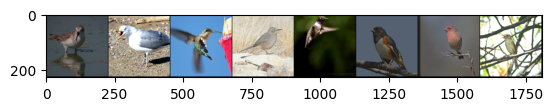

Labels:Western Sandpiper, Herring Gull (Adult), Ruby-throated Hummingbird (Female, immature), Curve-billed Thrasher, Black-chinned Hummingbird (Adult Male), Eastern Towhee, House Finch (Adult Male), Bell's Vireo


In [9]:
dataiter = iter(data['train'])
images, labels = next(dataiter)
images = images[:8]
print(images.size())

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Labels:" + ', '.join('%9s' % data['to_name'][labels[j].item()] for j in range(8)))

In [10]:
def train2(net, dataloader, epochs=1, start_epoch=0, lr=0.01, momentum=0.9, decay=0.0005, 
          verbose=1, print_every=10, state=None, checkpoint_path=None):
    net.to(device)
    net.train()
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    # scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=32, eta_min=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=8, T_mult=1, eta_min=1e-4)


    # Load previous training state
    if state:
        net.load_state_dict(state['net'])
        optimizer.load_state_dict(state['optimizer'])
        start_epoch = state['epoch']
        losses = state['losses']
        scheduler.load_state_dict(state['scheduler'])

    for epoch in range(start_epoch, epochs):
        sum_loss = 0.0

        iters = len(dataloader)
        for i, batch in enumerate(dataloader, 0):
            inputs, labels = batch[0].to(device), batch[1].to(device)

            optimizer.zero_grad()

            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction
            scheduler.step(epoch + i / iters)

            losses.append(loss.item())
            sum_loss += loss.item()

            if i % print_every == print_every-1:    # print every 10 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' % (epoch, i + 1, sum_loss / print_every))
                sum_loss = 0.0
        if checkpoint_path:
            state = {'epoch': epoch+1, 'net': net.state_dict(), 'optimizer': optimizer.state_dict(), 'losses': losses, 'scheduler': scheduler.state_dict()}
            torch.save(state, checkpoint_path + 'checkpoint-%d.pkl'%(epoch+1))
    return losses

In [11]:
# validate model
def valid(net, dataloader):
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            # assume batch size of 1
            if predicted.item() == labels[0]:
                correct += 1
            total += 1
    print(f"validation result: {correct} / {total} ({correct / total * 100}%) correct")
    return correct / total

In [12]:
# create model and initialize with pretrained weights except last layer
efficientnet = timm.create_model('efficientnet_b5', pretrained=True)
efficientnet.reset_classifier(555)
summary(efficientnet, input_size=(32, 3, 224, 224))

Layer (type:depth-idx)                        Output Shape              Param #
EfficientNet                                  [32, 555]                 --
├─Conv2d: 1-1                                 [32, 48, 112, 112]        1,296
├─BatchNormAct2d: 1-2                         [32, 48, 112, 112]        96
│    └─Identity: 2-1                          [32, 48, 112, 112]        --
│    └─SiLU: 2-2                              [32, 48, 112, 112]        --
├─Sequential: 1-3                             [32, 512, 7, 7]           --
│    └─Sequential: 2-3                        [32, 24, 112, 112]        --
│    │    └─DepthwiseSeparableConv: 3-1       [32, 24, 112, 112]        2,940
│    │    └─DepthwiseSeparableConv: 3-2       [32, 24, 112, 112]        1,206
│    │    └─DepthwiseSeparableConv: 3-3       [32, 24, 112, 112]        1,206
│    └─Sequential: 2-4                        [32, 40, 56, 56]          --
│    │    └─InvertedResidual: 3-4             [32, 40, 56, 56]          13,046
│   

In [ ]:
# train model from start
losses = train2(efficientnet, data['train'], epochs=20, lr=.01, print_every=10, checkpoint_path=checkpoints)

In [29]:
# load model from checkpoint
state = torch.load(checkpoints + 'checkpoint-16.pkl')
efficientnet.load_state_dict(state['net'])

<All keys matched successfully>

In [ ]:
# validate model
valid(efficientnet, data['valid'])

In [ ]:
# train model from checkpoint
losses = train2(efficientnet, data['train'], state=state, epochs=40, lr=.01, print_every=200, checkpoint_path=checkpoints)

In [40]:
def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='full')
# plt.plot(smooth(losses,50))

In [15]:
# generate predictions for the competition
def predict(net, dataloader, ofname):
    out = open(ofname, 'w')
    out.write("path,class\n")
    net.to(device)
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i, (images, labels) in enumerate(dataloader, 0):
            if i%100 == 0:
                print(i)
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            fname, _ = dataloader.dataset.samples[i]
            out.write("test/{},{}\n".format(fname.split('/')[-1], data['to_class'][predicted.item()]))
    out.close()

In [ ]:
# Load model from checkpoint
state = torch.load(checkpoints + 'checkpoint-40.pkl')
efficientnet.load_state_dict(state['net'])

predict(efficientnet, data['test'], checkpoints + "preds.csv")

# below are drafts

In [7]:
import pathlib
count = 0
for dirname, _, filenames in os.walk(BIRDS_DIR + '/' + 'train'):
    for filename in filenames:
        p = pathlib.Path(os.path.join(dirname, filename))
        if p.suffix.lower() in [".png", ".jpg"]:
            count += 1
print(count)

38562


In [10]:
from PIL import Image

widths, heights = [], []
for dirname, _, filenames in os.walk(BIRDS_DIR + '/' + 'train'):
    for filename in filenames:
        p = pathlib.Path(os.path.join(dirname, filename))
        if p.suffix.lower() in [".png", ".jpg"]:
            im = Image.open(str(p))
            width, height = im.size
            widths.append(width)
            heights.append(height)
        # if len(widths) % 100 == 0:
        #     print(len(widths))

In [11]:
widths[0], heights[0]

(750, 508)

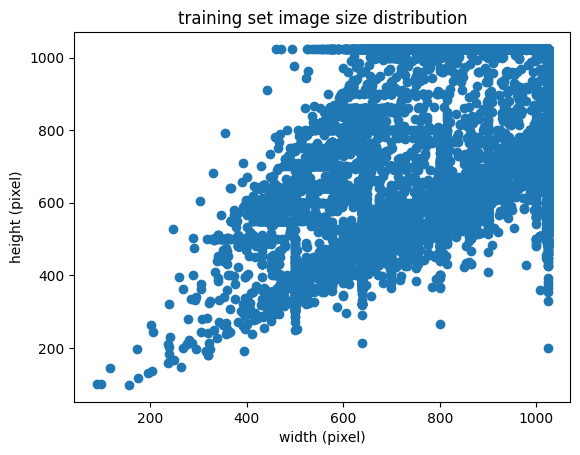

In [16]:
plt.figure()
plt.scatter(widths, heights)
plt.xlabel('width (pixel)')
plt.ylabel('height (pixel)')
plt.title('training set image size distribution')
plt.show()

In [23]:
a = torch.zeros((10,))
sgd = optim.SGD([a], lr=0.01)
coslr = optim.lr_scheduler.CosineAnnealingWarmRestarts(sgd, T_0=8, T_mult=1, eta_min=1e-4)
res = []
for i in range(20):
    coslr.step(i)
    res.append(coslr.get_last_lr())

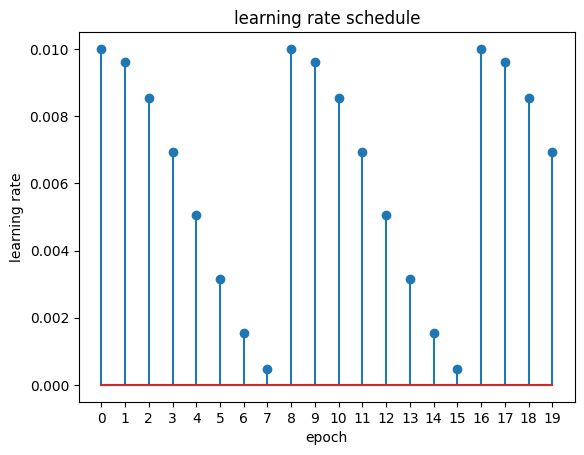

In [25]:
plt.figure()
plt.stem([str(x) for x in range(20)], res)
plt.title('learning rate schedule')
plt.xlabel('epoch')
plt.ylabel('learning rate')
plt.show()

In [27]:
state = torch.load(checkpoints + 'checkpoint-20.pkl')
efficientnet = timm.create_model('efficientnet_b5', pretrained=True)
efficientnet.reset_classifier(555)
efficientnet.load_state_dict(state['net'])

<All keys matched successfully>

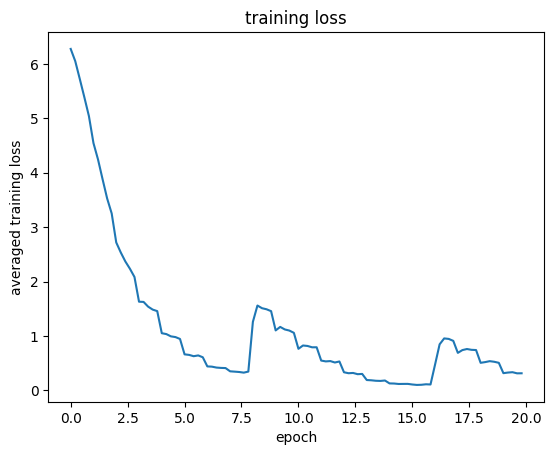

In [50]:
losses = state['losses']
plt.figure()
# plt.plot(np.arange(20 * 1085) / 1085, losses)
plt.plot(np.arange(20 * 5) / 5, np.average(np.array(losses).reshape((100, 217)), axis=1))
plt.xlabel('epoch')
plt.ylabel('averaged training loss')
plt.title('training loss')
plt.show()